In [ ]:
# импортируем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Предсказание уровней воды на реке Амур

In [ ]:
# Описание данных
# https://github.com/sberbank-ai/no_flood_with_ai_aij2020/blob/main/desc/datasets_description_ru.md
# Описание задачи, которую можно решать:
# https://github.com/sberbank-ai/no_flood_with_ai_aij2020
# Данные 
# https://storage.yandexcloud.net/datasouls-ods/materials/c8b9bab3/datasets.zip

Загружаем архив со всеми данными

In [ ]:
%%bash
curl -o datasets.zip "https://storage.yandexcloud.net/datasouls-ods/materials/c8b9bab3/datasets.zip" 
unzip -o -q datasets.zip
rm -f datasets.zip
rm -r __MACOSX

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  303M  100  303M    0     0  14.1M      0  0:00:21  0:00:21 --:--:-- 14.6M


Полный архив данных наблюдений на гидрологических постах сети Росгидромета за период с 1984 по 2018 гг. Содержит данные об уровнях воды, расходах, температуре воды, наблюдения за поверхностью воды (становление ледостава, вскрытие)

In [ ]:
path_to_hydro = './datasets/hydro/'
files_hydro = ! ls -1 $path_to_hydro

In [ ]:
# Ежедневные значения уровня воды на гидропостах
files_hydro_daily = [f for f in files_hydro if '_daily' in f] 

In [ ]:
len(files_hydro_daily)

198

In [ ]:
%%time
# Собираем в pandas dataframe 
daily = []
for filename in files_hydro_daily:
    tmp = pd.read_csv(path_to_hydro + filename, \
    encoding = 'cp1251', sep = ';', skiprows = 2, index_col = False, \
    names = ['date','stage_avg','stage_min','stage_max','temp','water_code'])
    tmp['id'] = int(filename.replace('_daily.csv', ''))
    daily.append(tmp)
daily = pd.concat(daily)

In [ ]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2201371 entries, 0 to 5630
Data columns (total 7 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   date        object
 1   stage_avg   object
 2   stage_min   object
 3   stage_max   object
 4   temp        object
 5   water_code  object
 6   id          int64 
dtypes: int64(1), object(6)
memory usage: 134.4+ MB


In [ ]:
# Переиндексируем:
daily.reset_index(drop=True, inplace=True)

In [ ]:
# Очищаем от мусора + приводим к нужным типам

daily['date'] = pd.to_datetime(daily['date'], format='%d.%m.%Y')

daily.loc[daily['stage_avg'] == '       ', 'stage_avg'] = np.nan ## иначе из string нельзя перевести в float
daily['stage_avg'] = daily['stage_avg'].astype('float16')

daily.loc[daily['stage_min'] == '       ', 'stage_min'] = np.nan ## иначе из string нельзя перевести в float
daily['stage_min'] = daily['stage_min'].astype('float16')

daily.loc[daily['stage_max'] == '       ', 'stage_max'] = np.nan ## иначе из string нельзя перевести в float
daily.loc[daily['stage_max'] =='****   ', 'stage_max'] = np.nan ## иначе из string нельзя перевести в float
daily['stage_max'] = daily['stage_max'].astype('float16')

In [ ]:
daily['temp'] = daily['temp'].astype('str')
daily['temp'] = daily['temp'].map(lambda x: x.strip())
daily.loc[~daily['temp'].str.contains('\.'), 'temp'] = np.nan
daily['temp'] = daily[~daily['temp'].isnull()]['temp'].map(lambda x: x.split('.')[0] + '.' + x.split('.')[1][:2])
daily['temp'] = daily['temp'].astype('float64')

In [ ]:
daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2201371 entries, 0 to 2201370
Data columns (total 7 columns):
 #   Column      Dtype         
---  ------      -----         
 0   date        datetime64[ns]
 1   stage_avg   float16       
 2   stage_min   float16       
 3   stage_max   float16       
 4   temp        float64       
 5   water_code  object        
 6   id          int64         
dtypes: datetime64[ns](1), float16(3), float64(1), int64(1), object(1)
memory usage: 79.8+ MB


<Figure size 1440x360 with 0 Axes>

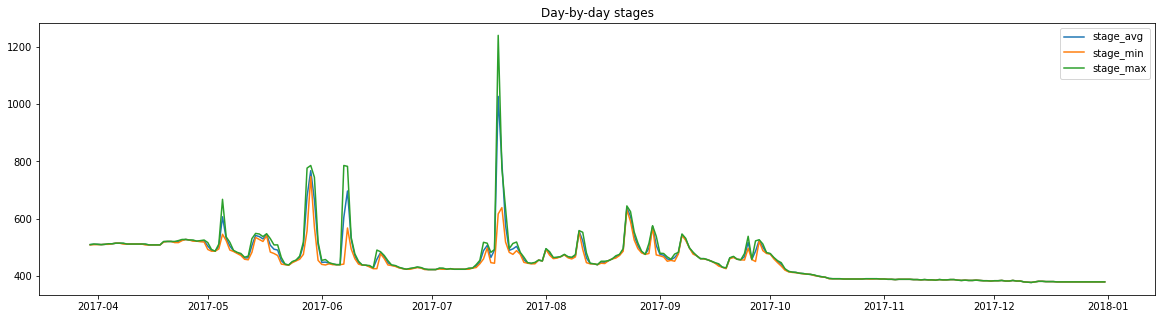

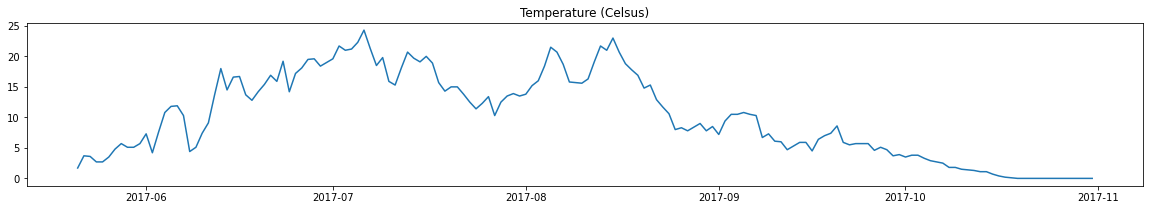

In [ ]:
date_start, date_end = '01-01-2017', '31-12-2017'
id = 6299

plt.figure(figsize = (20, 5))
sub_condition  = daily.date.between(date_start, date_end)&(daily.id == id)

stages = ['stage_avg', 'stage_min', 'stage_max']

plt.figure(figsize = (20, 5))
plt.title('Day-by-day stages')
for stage in stages:
  plt.plot(daily[sub_condition][['date'] + [stage]].set_index('date'), label = stage)
  plt.legend()
plt.show()

plt.figure(figsize = (20,3))
plt.title('Temperature (Celsus)')
plt.plot(daily[sub_condition][['date', 'temp']].set_index('date'))
plt.show()


2. Периодические значения (раз в 5 дней) высоты снега и толщины льда на гидропостах

In [ ]:
%%time
files_ice = [f for f in files_hydro if '_ice' in f]
print(len(files_ice))
# Собираем в pandas dataframe 
ice = []
for filename in files_ice:
    tmp = pd.read_csv(path_to_hydro + filename, \
    encoding = 'cp1251', sep = ';', skiprows = 2, index_col = False, \
    names = ['date','ice_high','snow_high','place_code'])
    tmp['id'] = int(filename.replace('_ice.csv', ''))
    ice.append(tmp)
ice = pd.concat(ice)

181
CPU times: user 706 ms, sys: 35.9 ms, total: 741 ms
Wall time: 742 ms


In [ ]:
# Приводим к нужным типам

ice['date'] = pd.to_datetime(ice['date'], format='%d.%m.%Y')

ice['ice_high'] = ice['ice_high'].astype('str')
ice['ice_high'] = ice['ice_high'].map(lambda x: x.strip())
ice.loc[ice['ice_high'] == '', 'ice_high'] = np.nan
ice['ice_high'] = ice['ice_high'].astype('float64')

ice['snow_high'] = ice['snow_high'].astype('str')
ice['snow_high'] = ice['snow_high'].map(lambda x: x.strip())
ice.loc[ice['snow_high'] == '', 'snow_high'] = np.nan
ice['snow_high'] = ice['snow_high'].astype('float64')

ice['place_code'] = ice['place_code'].astype('int16')

In [ ]:
%%time
# Сортируеи + переиндексируем:
ice.sort_values( ['id', 'date'], inplace = True)
ice.reset_index(drop=True, inplace=True)

CPU times: user 42.1 ms, sys: 0 ns, total: 42.1 ms
Wall time: 45.4 ms


In [ ]:
ice.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128389 entries, 0 to 128388
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        128389 non-null  datetime64[ns]
 1   ice_high    76688 non-null   float64       
 2   snow_high   67951 non-null   float64       
 3   place_code  128389 non-null  int16         
 4   id          128389 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int16(1), int64(1)
memory usage: 4.2 MB


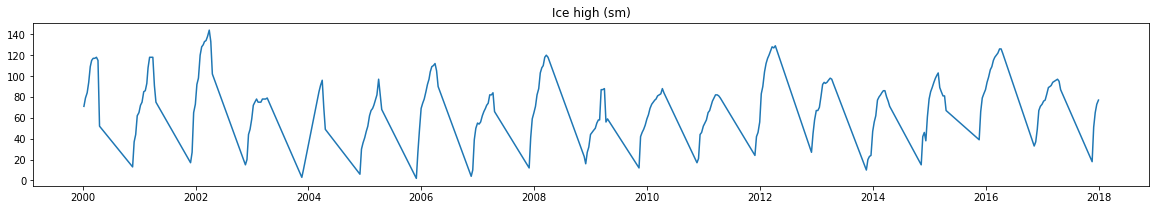

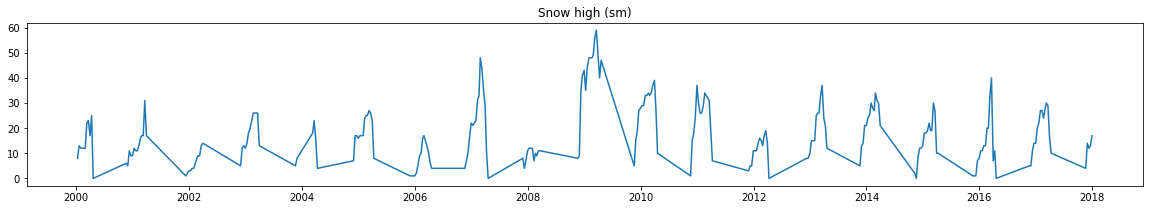

In [ ]:
date_start, date_end = '01-01-2000', '31-12-2020'
id = 6453
place_code = 13

sub_condition  = ice.date.between(date_start, date_end)&(ice.id == id)&(ice.place_code == 14)

plt.figure(figsize = (20,3))
plt.title('Ice high (sm)')
plt.plot(ice[sub_condition][['date', 'ice_high']].dropna().set_index('date'))
plt.show()

plt.figure(figsize = (20,3))
plt.title('Snow high (sm)')
plt.plot(ice[sub_condition][['date', 'snow_high']].dropna().set_index('date'))
plt.show()


In [ ]:
%%time
# Выгружаем готовые фреймы в pkl:

daily.to_pickle('daily.pkl')
ice.to_pickle('ice.pkl')

!ls -l --block-size=M

total 78M
-rw-r--r-- 1 root root 74M Oct 22 16:33 daily.pkl
drwxr-xr-x 8 root root  1M Oct 13 05:07 datasets
-rw-r--r-- 1 root root  5M Oct 22 16:33 ice.pkl
drwxr-xr-x 1 root root  1M Oct 14 16:31 sample_data
CPU times: user 176 ms, sys: 128 ms, total: 304 ms
Wall time: 425 ms


## Датафрейм daily

Cобран из 198 csv-файлов 

Содержат ежедневные значения уровня воды на гидрологический постах за период с 1984 по 2018 гг.

date - дата измерений

stage_avg - средний уровень воды за день (см.)

stage_min - минимальный уровень воды за день (см.)

stage_max – максимальный уровень воды за день (см.)

temp - средняя температура воды за день (°C)

water_code - код состояния водного объекта

id - номер гидрологического поста

## Датафрейм ice

Cобран из 181 csv-файлов 

Содержит периодические значения (раз в 5 дней) высоты снега и толщины льда на гидрологическом посте

date datetime64[ns] - дата измерения

ice_high Толщина льда (см)

snow_high Высота снега (см)

place_code'Место измер - код места ледовых измерений

id - номер гидрологического поста

#Михаил - meteo_new dataset

In [ ]:
# Получаем данные из папки
path_to_meteo_new = './datasets/meteo_new/'
files_meteo_new = ! ls -1 $path_to_meteo_new

In [ ]:
# Убираем два лишних файла
files_meteo_new = files_meteo_new[:-2]

In [ ]:
%%time
# Собираем в pandas dataframe 
meteo_new_df = []
for filename in files_meteo_new:
    tmp = pd.read_csv(path_to_meteo_new + filename)
    meteo_new_df.append(tmp)
meteo_new_df = pd.concat(meteo_new_df)

CPU times: user 13.2 s, sys: 1.09 s, total: 14.3 s
Wall time: 14.3 s


In [ ]:
# Выбрасываем лишние колонки
meteo_new_df.drop(meteo_new_df.columns[0], axis=1, inplace=True)

In [ ]:
meteo_new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3580001 entries, 0 to 105188
Data columns (total 57 columns):
 #   Column                                                   Dtype  
---  ------                                                   -----  
 0   stationNumber                                            int64  
 1   year                                                     int64  
 2   month                                                    int64  
 3   day                                                      int64  
 4   time                                                     int64  
 5   localYear                                                int64  
 6   localMonth                                               int64  
 7   localDay                                                 int64  
 8   localTimePeriod                                          int64  
 9   timePeriodNum                                            int64  
 10  localTime                                  

In [ ]:
# Связываем колонки с временем и датой в одну колонку
meteo_new_df["date"] = meteo_new_df["day"].astype(str) + "/" + \
                       meteo_new_df["month"].astype(str) + "/" + \
                       meteo_new_df["year"].astype(str) + " " + \
                       meteo_new_df["time"].astype(str) + ":00:00"

In [ ]:
# Связываем колонки с локальным временем и датой в одну колонку
meteo_new_df["localDate"] = meteo_new_df["localDay"].astype(str) + "/" + \
                            meteo_new_df["localMonth"].astype(str) + "/" + \
                            meteo_new_df["localYear"].astype(str) + " " + \
                            meteo_new_df["localTimePeriod"].astype(str) + ":00:00"

In [ ]:
# Преобразовываем связанные колонки в datetime (очень медленно, нужна оптимизация)
%%time
meteo_new_df['date']= pd.to_datetime(meteo_new_df['date'])
meteo_new_df['localDate']= pd.to_datetime(meteo_new_df['localDate'])

CPU times: user 10min 40s, sys: 87.4 ms, total: 10min 40s
Wall time: 10min 41s


In [ ]:
# Выбрасываем теперь уже лишние колонки
meteo_new_df.drop(['day', 'localDay', 'month', 'localMonth', 'year', 'localYear', 'time', 'localTimePeriod'], axis='columns', inplace=True)

In [ ]:
meteo_new_df

,stationNumber,timePeriodNum,localTime,tz,startMeteoDay,horizontalVisibility,horizontalVisibilityQuality,horizontalVisibilitySign,cloudCoverTotal,cloudCoverTotalQuality,pastWeather,pastWeatherQuality,presentWeather,presentWeatherQuality,windDirection,windDirectionQuality,windSpeed,windSpeedQuality,windSpeedSign,maximumWindGustSpeed,maximumWindGustSpeedQuality,maximumWindGustSpeedSign,totalAccumulatedPrecipitation,totalAccumulatedPrecipitationQuality,soilTemperature,soilTemperatureQuality,groundMinimumTemperature,groundMinimumTemperatureQuality,airTemperature,airTemperatureQuality,minimumTemperatureAtHeightAndOverPeriodSpecified,minimumTemperatureAtHeightAndOverPeriodSpecifiedQuality,maximumTemperatureOverPeriodSpecified,maximumTemperatureOverPeriodSpecifiedQuality,relativeHumidity,relativeHumidityQuality,vapourPressure,vapourPressureQuality,dewpointTemperature,dewpointTemperatureQuality,pressure,pressureQuality,pressureReducedToMeanSeaLevel,pressureReducedToMeanSeaLevelQuality,characteristicOfPressureTendency,characteristicOfPressureTendencyQuality,HourPressureChange3,HourPressureChange3Quality,stationId,date,localDate
0,31915,5,10,9,19,98.0,0,0.0,0.0,0,0.0,0,2.0,0,270.0,0,3.0,0,0,4.0,0,0,0.0,5,-22.0,0,-22.0,0,-17.9,0,-18.7,0,-17.8,0,50.0,0,0.80,0,-25.8,0,995.3,0,1023.7,0,2.0,0,0.7,0,4443141,1984-01-01 00:00:00,1984-01-01 03:00:00
1,31915,6,13,9,19,98.0,0,0.0,4.0,0,0.0,0,3.0,0,315.0,0,4.0,0,0,6.0,0,0,0.0,5,-9.0,0,-9.0,0,-12.1,0,-17.6,0,-11.9,0,56.0,0,1.10,0,-19.3,0,995.7,0,1023.5,0,2.0,0,0.4,0,4443141,1984-01-01 03:00:00,1984-01-01 06:00:00
2,31915,7,16,9,19,98.0,0,0.0,7.0,0,1.0,0,2.0,0,315.0,0,3.0,0,0,8.0,0,0,0.0,5,-13.0,0,-13.0,0,-12.0,0,-12.5,0,-11.2,0,52.0,0,1.20,0,-20.3,0,995.8,0,1023.6,0,2.0,0,0.1,0,4443141,1984-01-01 06:00:00,1984-01-01 09:00:00
3,31915,8,19,9,19,59.0,0,0.0,10.0,0,7.0,0,71.0,0,70.0,0,1.0,0,0,5.0,0,0,0.0,0,-20.0,0,-20.0,0,-17.1,0,-17.1,0,-12.0,0,82.0,0,0.30,0,-19.7,0,997.5,0,1025.9,0,2.0,0,1.7,0,4443141,1984-01-01 09:00:00,1984-01-01 12:00:00
4,31915,1,22,9,19,70.0,0,0.0,3.0,0,7.0,0,1.0,0,270.0,0,3.0,0,0,4.0,0,0,0.0,0,-23.0,0,-23.0,0,-20.5,0,-20.6,0,-17.1,0,89.0,0,0.10,0,-21.7,0,998.8,0,1027.6,0,2.0,0,1.3,0,4443141,1984-01-01 12:00:00,1984-02-01 15:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105184,31253,4,9,8,20,NaN,0,0.0,0.0,0,1.0,0,2.0,0,219.0,0,1.0,0,0,3.0,0,0,0.0,5,-10.3,0,NaN,6,-7.2,0,-16.3,0,-7.1,0,54.0,0,1.65,0,-14.9,0,966.2,0,1012.1,0,2.0,0,0.3,0,5472891,2020-03-31 00:00:00,2020-03-31 00:00:00
105185,31253,5,12,8,20,NaN,0,0.0,0.0,0,0.0,0,2.0,0,235.0,0,4.0,0,0,8.0,0,0,0.0,5,-2.5,0,NaN,6,-2.7,0,-8.9,0,-2.7,0,46.0,0,2.72,0,-12.7,0,965.4,0,1010.7,0,8.0,0,0.8,0,5472891,2020-03-31 03:00:00,2020-03-31 03:00:00
105186,31253,6,15,8,20,NaN,0,0.0,4.0,0,0.0,0,2.0,0,227.0,0,4.0,0,0,10.0,0,0,0.0,5,-0.2,0,NaN,6,0.5,0,-2.7,0,0.5,0,34.0,0,4.20,0,-13.6,0,963.7,0,1008.2,0,7.0,0,1.7,0,5472891,2020-03-31 06:00:00,2020-03-31 06:00:00
105187,31253,7,18,8,20,NaN,0,0.0,9.0,0,1.0,0,2.0,0,235.0,0,2.0,0,0,8.0,0,0,0.0,5,-0.4,0,NaN,6,-0.1,0,-0.9,0,1.0,0,33.0,0,4.08,0,-14.5,0,962.4,0,1007.0,0,7.0,0,1.3,0,5472891,2020-03-31 09:00:00,2020-03-31 09:00:00


In [ ]:
# В таблице очень много разряженных данных, уберем те колонки, где нулей больше 70 процентов
meteo_new_df = meteo_new_df.loc[:, (meteo_new_df==0).mean() < .7]

In [ ]:
# В таблице есть данные с пропусками, заполним их средним значением колонки
meteo_new_df = meteo_new_df.fillna(meteo_new_df.mean())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


In [ ]:
meteo_new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3580001 entries, 0 to 105188
Data columns (total 29 columns):
 #   Column                                            Dtype         
---  ------                                            -----         
 0   stationNumber                                     int64         
 1   timePeriodNum                                     int64         
 2   localTime                                         int64         
 3   tz                                                int64         
 4   startMeteoDay                                     int64         
 5   horizontalVisibility                              float64       
 6   horizontalVisibilityQuality                       int64         
 7   cloudCoverTotal                                   float64       
 8   pastWeather                                       float64       
 9   presentWeather                                    float64       
 10  windDirection                              

#Анна

In [ ]:
path_to_meteo = './datasets/meteo/'
files_meteo = ! ls -1 $path_to_meteo

meteo_df - это датафрейм, собранный из 108 файлов meteo/NNNNNNN.csv, где NNNNNNN номер синтаптической станции
meteo_df содержит архив наблюдений на метеостанциях сети Росгидромета с 1985 по 2018, всего 108 станций  
в датафрейме 9959296 строк, 21 колонка  
Названия колонок:  
1 station_name Название станции  
2 station_id Идентификатор станции   
3 visibility_distance Горизонтальная дальность видимости  
4 visibility_distance_quality Признак качества  
5 wind_direction Направление ветра  
6 wind_direction_quality Признак качества  
7 wind_speed_avg Средняя скорость ветра  
8 wind_speed_avg_quality Признак качества  
9 wind_speed_sign Признак наличия знака >  
10 wind_speed_max Максимальное скорость ветра  
11 wind_speed_max_quality Признак качества  
12 wind_speed_max_sign Признак наличия знака >  
13 precipitation_amount Сумма осадков за период между сроками  
14 precipitation_amount_quality Признак качества  
15 temperature_ground Температура поверхности почвы в срок  
16 temperature_ground_quality Признак качества  
17 temperature_air Температура воздуха в срок по сухому терм-ру  
18 temperature_air_quality Признак качества  
19 humidity Относительная влажность воздуха в срок  
20 humidity_quality Признак качества  
21 time Срок наблюдения  
Типы данных float64(10), int64(9), object(2)  


In [ ]:
len(files_meteo)

108

In [ ]:
%%time
# Собираем в pandas dataframe 
meteo_df = []
for filename in files_meteo:
    tmp = pd.read_csv(path_to_meteo + filename, sep = ';') #надо ли еще минус первую строчку у каждого файла и сделать заголовки для таблицы? оно вроде нормально объединилось
    meteo_df.append(tmp)
meteo_df = pd.concat(meteo_df)

CPU times: user 17.6 s, sys: 3.56 s, total: 21.2 s
Wall time: 21.2 s


In [ ]:
# Переиндексируем:
meteo_df.reset_index(drop=True, inplace=True)

In [ ]:
meteo_df.head(2)

,station_name,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality,time
0,GAMOV,4263131,NaN,6,254.0,0,5.0,0,NaN,7.0,0,NaN,NaN,5,NaN,6,1.2,0,76.0,0,2013-04-17 21:00:00
1,GAMOV,4263131,NaN,6,NaN,6,NaN,6,NaN,NaN,6,NaN,NaN,5,NaN,6,NaN,6,NaN,6,2013-04-17 18:00:00


In [ ]:
meteo_df.tail(2)

,station_name,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality,time
9959294,TINDA,5522471,56.0,0,20.0,0,2.0,0,NaN,7.0,0,NaN,NaN,5,7.3,0,5.1,0,95.0,0,2000-05-25 03:00:00
9959295,TINDA,5522471,56.0,0,215.0,0,1.0,0,NaN,4.0,0,NaN,5.6,0,9.0,0,8.0,0,100.0,0,2000-05-25 00:00:00


In [ ]:
meteo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9959296 entries, 0 to 9959295
Data columns (total 21 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0   station_name                  object 
 1   station_id                    int64  
 2   visibility_distance           float64
 3   visibility_distance_quality   int64  
 4   wind_direction                float64
 5   wind_direction_quality        int64  
 6   wind_speed_avg                float64
 7   wind_speed_avg_quality        int64  
 8   wind_speed_sign               float64
 9   wind_speed_max                float64
 10  wind_speed_max_quality        int64  
 11  wind_speed_max_sign           float64
 12  precipitation_amount          float64
 13  precipitation_amount_quality  int64  
 14  temperature_ground            float64
 15  temperature_ground_quality    int64  
 16  temperature_air               float64
 17  temperature_air_quality       int64  
 18  humidity              

In [ ]:
meteo_df.describe()

,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality
count,9.959296e+06,6.935735e+06,9.959296e+06,9.658505e+06,9.959296e+06,9.657235e+06,9.959296e+06,6.0,9.604971e+06,9.959296e+06,97.0,676849.000000,9.959296e+06,8.976419e+06,9.959296e+06,9.735092e+06,9.959296e+06,9.652774e+06,9.959296e+06
mean,5.014255e+06,9.268986e+01,1.560392e+00,1.463441e+02,1.962744e-01,1.883636e+00,1.970453e-01,0.0,4.440605e+00,2.297958e-01,0.0,2.867632,4.689867e+00,1.265210e-01,6.108870e-01,-3.730464e-01,1.551766e-01,7.043046e+01,1.995857e-01
std,2.886573e+05,1.393688e+01,2.377268e+00,1.339412e+02,1.114293e+00,1.957506e+00,1.116247e+00,0.0,3.544410e+00,1.193106e+00,0.0,5.713966,1.289238e+00,2.035434e+01,1.663553e+00,1.705032e+01,9.948064e-01,2.021177e+01,1.123329e+00
min,4.263131e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.0,0.000000,0.000000e+00,-5.960000e+01,0.000000e+00,-7.680000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.883591e+06,9.600000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,2.000000e+00,0.000000e+00,0.0,0.200000,5.000000e+00,-1.600000e+01,0.000000e+00,-1.450000e+01,0.000000e+00,5.600000e+01,0.000000e+00
50%,5.043101e+06,9.900000e+01,0.000000e+00,1.400000e+02,0.000000e+00,1.000000e+00,0.000000e+00,0.0,4.000000e+00,0.000000e+00,0.0,0.800000,5.000000e+00,7.000000e-01,0.000000e+00,1.700000e+00,0.000000e+00,7.400000e+01,0.000000e+00
75%,5.233581e+06,9.900000e+01,5.000000e+00,2.680000e+02,0.000000e+00,3.000000e+00,0.000000e+00,0.0,6.000000e+00,0.000000e+00,0.0,3.000000,5.000000e+00,1.550000e+01,0.000000e+00,1.410000e+01,0.000000e+00,8.700000e+01,0.000000e+00
max,5.522471e+06,9.900000e+01,7.000000e+00,9.990000e+02,7.000000e+00,9.600000e+01,7.000000e+00,0.0,4.100000e+01,7.000000e+00,0.0,620.700000,7.000000e+00,1.023000e+02,8.000000e+00,9.030000e+01,7.000000e+00,1.200000e+02,7.000000e+00


In [ ]:
meteo_df.value_counts()

station_name  station_id  visibility_distance  visibility_distance_quality  wind_direction  wind_direction_quality  wind_speed_avg  wind_speed_avg_quality  wind_speed_sign  wind_speed_max  wind_speed_max_quality  wind_speed_max_sign  precipitation_amount  precipitation_amount_quality  temperature_ground  temperature_ground_quality  temperature_air  temperature_air_quality  humidity  humidity_quality  time               
MALIN25       4982991     99.0                 0                            64.0            0                       0.0             4                       0.0              0.0             4                       0.0                  211.1                 7                             -2.4                0                            64.7            7                        104.0     4                 1989-09-26 18:00:00    1
                          96.0                 6                            64.0            0                       0.0             4              

In [ ]:
meteo_df.shape

(9959296, 21)

In [ ]:
meteo_df[93006:93010]

,station_name,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality,time
93006,GAMOV,4263131,98.0,0,65.0,0,10.0,0,NaN,18.0,0,NaN,NaN,5,17.6,0,10.6,0,88.0,0,2000-05-31 06:00:00
93007,GAMOV,4263131,98.0,0,45.0,0,11.0,0,NaN,19.0,0,NaN,NaN,5,13.1,0,11.2,0,86.0,0,2000-05-31 09:00:00
93008,ANUCH26,4393311,99.0,0,250.0,0,1.0,0,NaN,3.0,0,NaN,NaN,5,-2.3,0,-4.2,0,98.0,0,2013-04-17 21:00:00
93009,ANUCH26,4393311,NaN,5,250.0,0,1.0,0,NaN,3.0,0,NaN,NaN,5,-2.3,0,-4.6,0,98.0,0,2013-04-17 18:00:00


In [ ]:
meteo_df.groupby('station_name').count()

,station_id,visibility_distance,visibility_distance_quality,wind_direction,wind_direction_quality,wind_speed_avg,wind_speed_avg_quality,wind_speed_sign,wind_speed_max,wind_speed_max_quality,wind_speed_max_sign,precipitation_amount,precipitation_amount_quality,temperature_ground,temperature_ground_quality,temperature_air,temperature_air_quality,humidity,humidity_quality,time
station_name,,,,,,,,,,,,,,,,,,,,
AKSHA,98120,85818,98120,97931,98120,97931,98120,0,97931,98120,0,3901,98120,98076,98120,98120,98120,98120,98120,98120
ALEKSZD,93504,77264,93504,93504,93504,93504,93504,0,93504,93504,0,5268,93504,93440,93504,93504,93504,93504,93504,93504
ANUCH26,90336,46999,90336,90330,90336,90331,90336,0,90329,90336,0,6428,90336,90336,90336,90336,90336,90336,90336,90336
ARHARA,99344,83948,99344,99214,99344,99214,99344,0,99214,99344,3,7157,99344,99231,99344,99231,99344,99210,99344,99344
ARSENEV,1200,696,1200,1200,1200,1200,1200,0,1200,1200,0,93,1200,1200,1200,1200,1200,1200,1200,1200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VURMI,99344,54595,99344,92321,99344,92321,99344,0,92319,99344,1,7589,99344,87002,99344,93543,99344,91848,99344,99344
VYZEMSK,99104,66783,99104,98155,99104,98155,99104,0,97653,99104,0,7166,99104,98885,99104,98846,99104,98846,99104,99104
YMKUN,99344,66896,99344,99344,99344,99344,99344,0,99344,99344,0,5899,99344,99258,99344,99344,99344,99344,99344,99344


In [ ]:
# Посчитаем количества NaN элементов в колонках
meteo_df.isnull().sum()

station_name                          0
station_id                            0
visibility_distance             3023561
visibility_distance_quality           0
wind_direction                   300791
wind_direction_quality                0
wind_speed_avg                   302061
wind_speed_avg_quality                0
wind_speed_sign                 9959290
wind_speed_max                   354325
wind_speed_max_quality                0
wind_speed_max_sign             9959199
precipitation_amount            9282447
precipitation_amount_quality          0
temperature_ground               982877
temperature_ground_quality            0
temperature_air                  224204
temperature_air_quality               0
humidity                         306522
humidity_quality                      0
time                                  0
dtype: int64

In [ ]:
%%time
# Выгружаем готовые фреймы в pkl:

meteo_df.to_pickle('meteo_df.pkl')


!ls -l --block-size=M

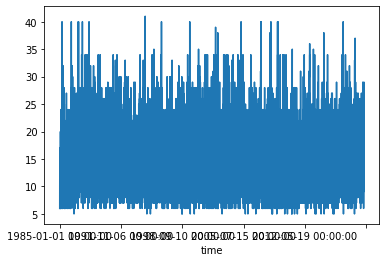

In [ ]:
# пока копия графика Максима Бобурова
wind_max = meteo_df.groupby(['time'])['wind_speed_max'].max()
wind_max.plot()

#Максим Бобуров

In [ ]:
# Получаем данные из папки
path_to_hydro_2018_2020 = './datasets/hydro_2018-2020/'
files_hydro_2018_2020 = ! ls -1 $path_to_hydro_2018_2020

In [ ]:
%%time
# Собираем в pandas dataframe 
hydro_2018_2020_df = []
for filename in files_hydro_2018_2020:
    tmp = pd.read_csv(path_to_hydro_2018_2020 + filename, sep = ';')
    hydro_2018_2020_df.append(tmp)
hydro_2018_2020_df = pd.concat(hydro_2018_2020_df)

CPU times: user 700 ms, sys: 102 ms, total: 802 ms
Wall time: 810 ms


In [ ]:
# Переименовываем колонки
hydro_2018_2020_df.columns = ['Data', 'Level_water', 'id']

# /hydro_2019-2020

### new_data_all.csv

> Файл с данными только об уровнях воды за период 01-01-1984 — 01-10-2020. Содержит не только архивные данные, но и оперативные с 2018 по настоящее время.

- 'Data' - дата замера

- 'Level_water' - максимальный уровень за день

- 'id' - номер гидрологического поста

### new_data_target.csv

> Подмножество файла new_data_all.csv для целевых гидрологических постов

In [ ]:
hydro_2018_2020_df.head()

,Data,Level_water,id
0,2020-10-01 00:00:00,232.0,5116
1,1986-06-20 00:00:00,278.0,5292
2,1986-06-22 00:00:00,67.0,6022
3,1986-06-23 00:00:00,323.0,5216
4,1986-06-22 00:00:00,112.0,5094


In [ ]:
hydro_2018_2020_df.describe()

,Level_water,id
count,2.313697e+06,2.337476e+06
mean,2.315219e+02,5.664184e+03
std,2.686035e+02,5.513401e+02
min,-4.270000e+02,5.001000e+03
25%,1.120000e+02,5.160000e+03
50%,1.920000e+02,5.420000e+03
75%,3.220000e+02,6.291000e+03
max,1.207100e+04,6.574000e+03


In [ ]:
# Удаляем из колонки Data ненужное значение времени
from datetime import datetime, timedelta
hydro_2018_2020_df['Data'] = pd.to_datetime(hydro_2018_2020_df['Data']).dt.date

hydro_2018_2020_df

,Data,Level_water,id
0,2020-10-01,232.0,5116
1,1986-06-20,278.0,5292
2,1986-06-22,67.0,6022
3,1986-06-23,323.0,5216
4,1986-06-22,112.0,5094
...,...,...,...
105852,2018-10-27,309.0,5004
105853,2018-05-04,59.0,6296
105854,2018-10-16,93.0,5012
105855,2019-05-25,28.0,5024


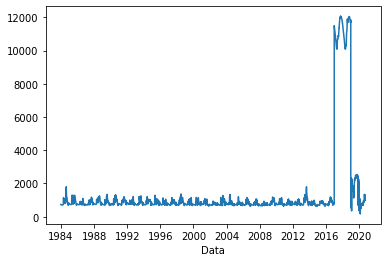

In [ ]:
level_max = hydro_2018_2020_df.groupby(['Data'])['Level_water'].max()
level_max.plot()

In [ ]:
grouped_df = hydro_2018_2020_df.groupby(['id'])['Level_water'].value_counts(bins=4)
grouped_df

id                    
5001  (-31.163, 260.5]    6623
      (260.5, 551.0]      5789
      (551.0, 841.5]       818
      (841.5, 1132.0]       59
5002  (374.0, 650.0]      6379
                          ... 
6573  (180.5, 203.75]        8
6574  (16.5, 62.0]        4266
      (62.0, 107.5]        860
      (-29.183, 16.5]      586
      (107.5, 153.0]        79
Name: Level_water, Length: 792, dtype: int64

In [ ]:
# Усредняем пропущенные значения
hydro_2018_2020_df = hydro_2018_2020_df.fillna(hydro_2018_2020_df.mean())

In [ ]:
num_id = hydro_2018_2020_df.sort_values(['id','Level_water'])
num_id

,Data,Level_water,id
81578,1986-11-19,-30.0000,5001
79442,1986-11-20,-29.0000,5001
85154,1986-11-18,-26.0000,5001
81592,1986-11-17,-22.0000,5001
81839,1986-11-16,-20.0000,5001
...,...,...,...
2228480,2008-02-21,231.5219,6574
2228533,2008-02-24,231.5219,6574
2229639,2008-02-25,231.5219,6574
2229757,2008-02-26,231.5219,6574
